In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import random
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import Delaunay, ConvexHull
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, to_rgba
import matplotlib.patches as patches
import os
import scipy.linalg as sclinalg
import copy

In [2]:
def format_func(value, tick_number):
    # find number of multiples of pi/6
    N = int(np.round(6 * value / np.pi))
    if N == 0:
        return "0"
    elif N == 1:
        return r"$\pi/6$"
    elif N == 2:
        return r"$2\pi/6$"
    elif N == 3:
        return r"$3\pi/6$"
    elif N == 4:
        return r"$4\pi/6$"
    elif N == 5:
        return r"$5\pi/6$"
    elif N == 6:
        return r"$\pi$"
    elif N % 6 > 0:
        return r"${0}\pi/6$".format(N)
    else:
        return r"${0}\pi$".format(N // 6)

In [3]:
'''
Parameters
'''
radius = 1
res = 40
rho = 6.371e6
R = 1.496e11

sigma = 0.001
nwater = 1.33
epsilon = 0.000000001

day = 17
Ndays = 200
year = Ndays*day
omega_day =  2*np.pi/day 
omega_year = 2*np.pi/year


delta_t = 1
delta_phi = np.pi/res
delta_theta = np.pi/res
delta_Omega = delta_phi*delta_theta 

hours = np.arange(0, day)
time_array = hours.copy()

N_ave = 187

for i in range(1, Ndays):
    time_array = np.append(time_array, hours + i*year/Ndays)

time_res = len(time_array)
print(time_res)

3400


In [4]:
alphalist = [np.pi/6,np.pi/3,np.pi/2]
betalist = [0.0,np.pi/12,np.pi/6,np.pi/4,np.pi/3, 5*np.pi/12,np.pi/2]

M = len(alphalist)
N = len(betalist)

lamb_lamb_errorlist = np.zeros((M,N))
lamb_comp_errorlist = np.zeros((M,N))


comp_lamb_errorlist = np.zeros((M,N))
comp_comp_errorlist = np.zeros((M,N))

In [5]:
#load map


filename2 = 'V2Reflectivities_planet'+str(2)+'_res'+str(res)+'.npz'
loaded2  = np.load(filename2)

albedo_map = loaded2['lamb']
onlylamb_map = loaded2['onlylamb']
ocean_map = loaded2['glint']
seeliger_map = loaded2['seel']
albedo_pseudo = loaded2['pseudo']

albedo_pseudo_grid = albedo_pseudo.reshape((res,2*res), order = 'F')

SVCR = 0.1


In [6]:
for i in range(M):
    alpha = alphalist[i]
    for j in range(N):
        beta = betalist[j]

        print(alpha,beta)
        filename1 = 'NEWTmatrices_res'+str(res)+'_tres'+str(time_res)+'_a'+str(alpha)+'_b'+str(beta)+'.npz'
        loaded1 = np.load(filename1)
        Tlambv = loaded1['lamb']
        Tglintv = loaded1['glint']
        Tseelv = loaded1['seel']

        # light is only lambertian

        f_onlylamb = np.matmul(Tlambv, onlylamb_map)*rho**2/(R**2)
        f_real = f_onlylamb

        Tonlylamb = Tlambv 
        Tcomp = np.concatenate((Tlambv,Tglintv,Tseelv),axis = 1)

        Tonlylamb_pinv = np.linalg.pinv(Tonlylamb, rcond = SVCR)
        Tcomp_pinv = np.linalg.pinv(Tcomp, rcond = SVCR)

        Aonlylamb = np.matmul(Tonlylamb_pinv, f_real)
        Acomp = np.matmul(Tcomp_pinv, f_real)

        f_test_onlylamb = np.matmul(Tonlylamb, Aonlylamb)
        f_test_comp = np.matmul(Tcomp,Acomp)

        simple_error = (np.linalg.norm(f_real-f_test_onlylamb)/np.linalg.norm(f_real))**2
        comp_error = (np.linalg.norm(f_real-f_test_comp)/np.linalg.norm(f_real))**2

        lamb_lamb_errorlist[i,j] = simple_error
        lamb_comp_errorlist[i,j] = comp_error
        print('simple model error calculated')
        
        # light is composite

        f_complamb = np.matmul(Tlambv, albedo_map)*rho**2/(R**2)
        f_compglint = 2*np.matmul(Tglintv, ocean_map)*rho**2/(R**2)
        f_compseel = 2*np.matmul(Tseelv, seeliger_map)*rho**2/(R**2)

        f_total = f_complamb+f_compglint+f_compseel
        f_real = f_total
        
        Aonlylamb = np.matmul(Tonlylamb_pinv, f_real)
        Acomp = np.matmul(Tcomp_pinv, f_real)

        f_test_onlylamb = np.matmul(Tonlylamb, Aonlylamb)
        f_test_comp = np.matmul(Tcomp,Acomp)

        simple_error = (np.linalg.norm(f_real-f_test_onlylamb)/np.linalg.norm(f_real))**2
        comp_error = (np.linalg.norm(f_real-f_test_comp)/np.linalg.norm(f_real))**2

        comp_lamb_errorlist[i,j] = simple_error
        comp_comp_errorlist[i,j] = comp_error
        print('composite model error calculated')

0.5235987755982988 0.0
simple model error calculated
composite model error calculated
0.5235987755982988 0.2617993877991494
simple model error calculated
composite model error calculated
0.5235987755982988 0.5235987755982988
simple model error calculated
composite model error calculated
0.5235987755982988 0.7853981633974483
simple model error calculated
composite model error calculated
0.5235987755982988 1.0471975511965976
simple model error calculated
composite model error calculated
0.5235987755982988 1.3089969389957472
simple model error calculated
composite model error calculated
0.5235987755982988 1.5707963267948966
simple model error calculated
composite model error calculated
1.0471975511965976 0.0
simple model error calculated
composite model error calculated
1.0471975511965976 0.2617993877991494
simple model error calculated
composite model error calculated
1.0471975511965976 0.5235987755982988
simple model error calculated
composite model error calculated
1.0471975511965976 0

Lambertian signal, SVCR= 0.1


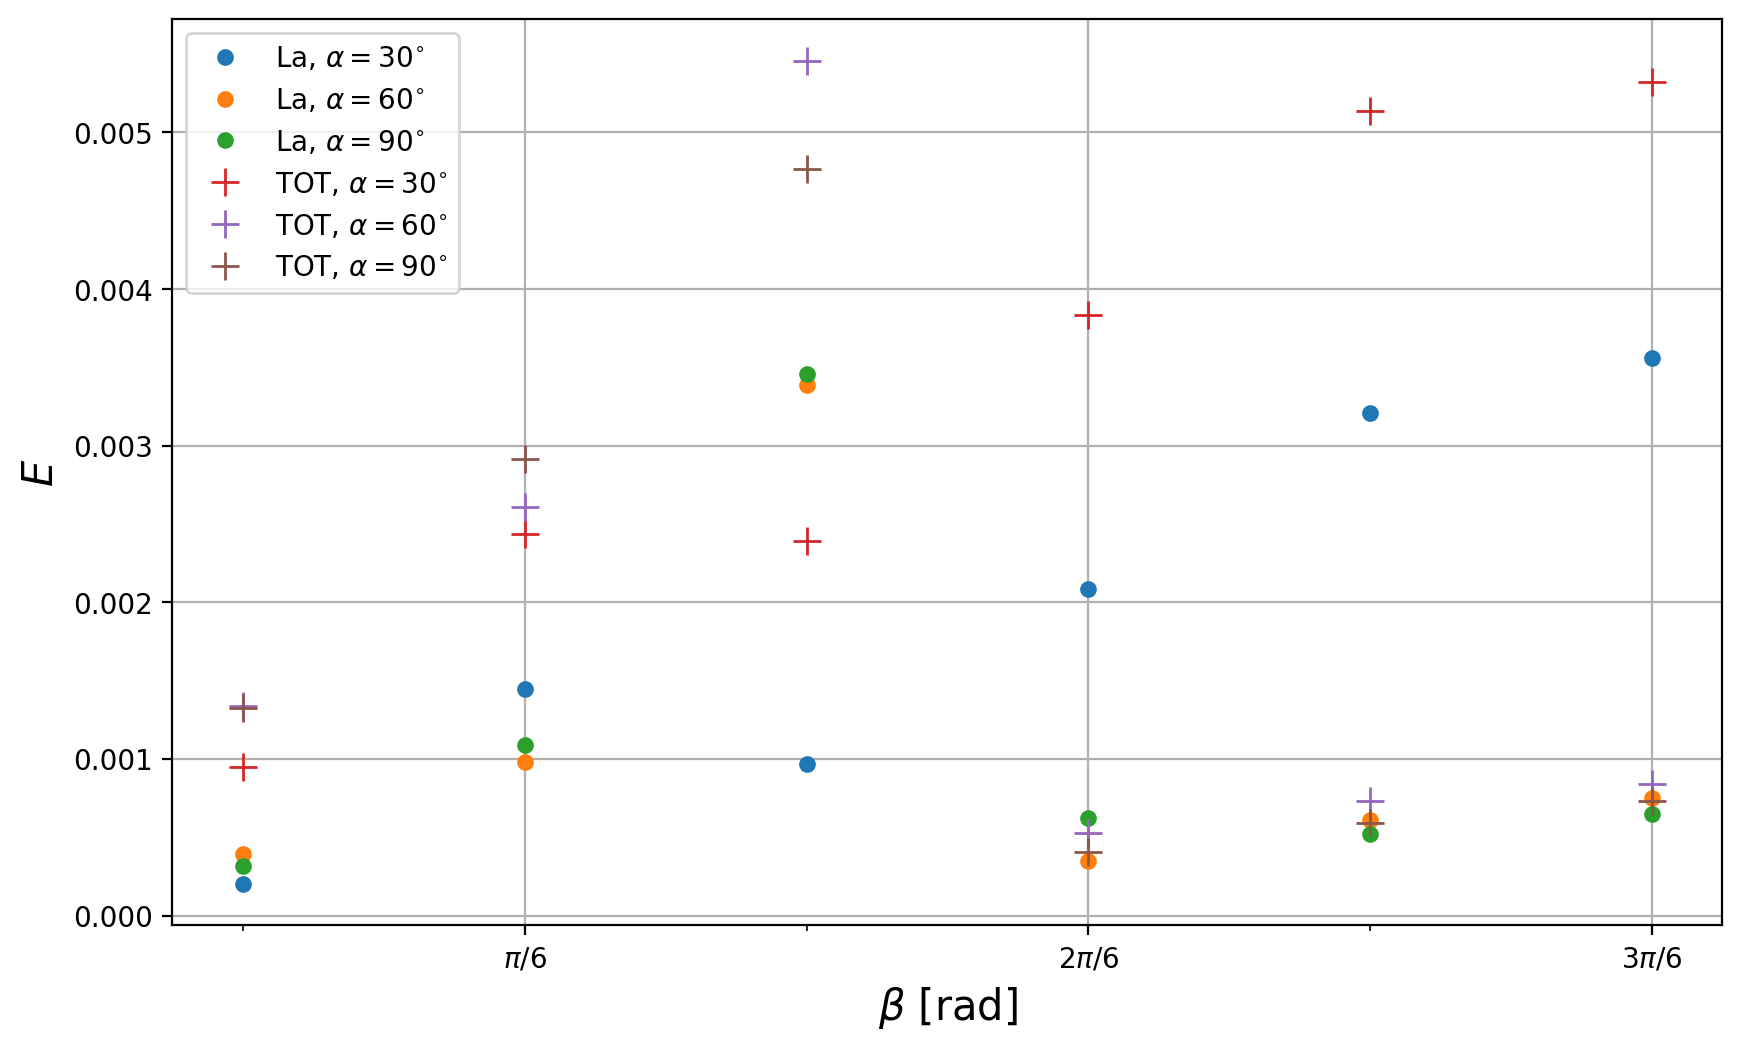

4.738171973034187 0 1


In [41]:
print('Lambertian signal, SVCR= '+str(SVCR))
f,ax=plt.subplots(figsize=(10,6), dpi=200)

ax.plot(betalist[1:],lamb_lamb_errorlist[0][1:], '.',label= 'La, '+r'$\alpha = 30^{\circ}$', alpha = 1, markersize=10)
ax.plot(betalist[1:],lamb_lamb_errorlist[1][1:], '.',label= 'La, '+r'$\alpha = 60^{\circ}$', alpha = 1, markersize=10)
ax.plot(betalist[1:],lamb_lamb_errorlist[2][1:], '.',label= 'La, '+r'$\alpha = 90^{\circ}$', alpha = 1, markersize=10)

ax.plot(betalist[1:],lamb_comp_errorlist[0][1:], '+',label= 'TOT, '+r'$\alpha = 30^{\circ}$', alpha = 1, markersize=10)
ax.plot(betalist[1:],lamb_comp_errorlist[1][1:], '+',label= 'TOT, '+r'$\alpha = 60^{\circ}$', alpha = 1, markersize=10)
ax.plot(betalist[1:],lamb_comp_errorlist[2][1:], '+',label= 'TOT, '+r'$\alpha = 90^{\circ}$', alpha = 1, markersize=10)

plt.xlabel(r'$\beta$ [rad]', fontsize = '15')
plt.ylabel(r'$E$', fontsize = '15')
plt.title('')
plt.legend()
plt.grid()
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 6))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
plt.show()

m = 0
for j in range(3):
    for i in range(6):
        if lamb_comp_errorlist[j,i+1]/lamb_lamb_errorlist[j,i+1] > m:
            m = lamb_comp_errorlist[j,i+1]/lamb_lamb_errorlist[j,i+1]
            a = j
            b = i+1
print(m,a,b)

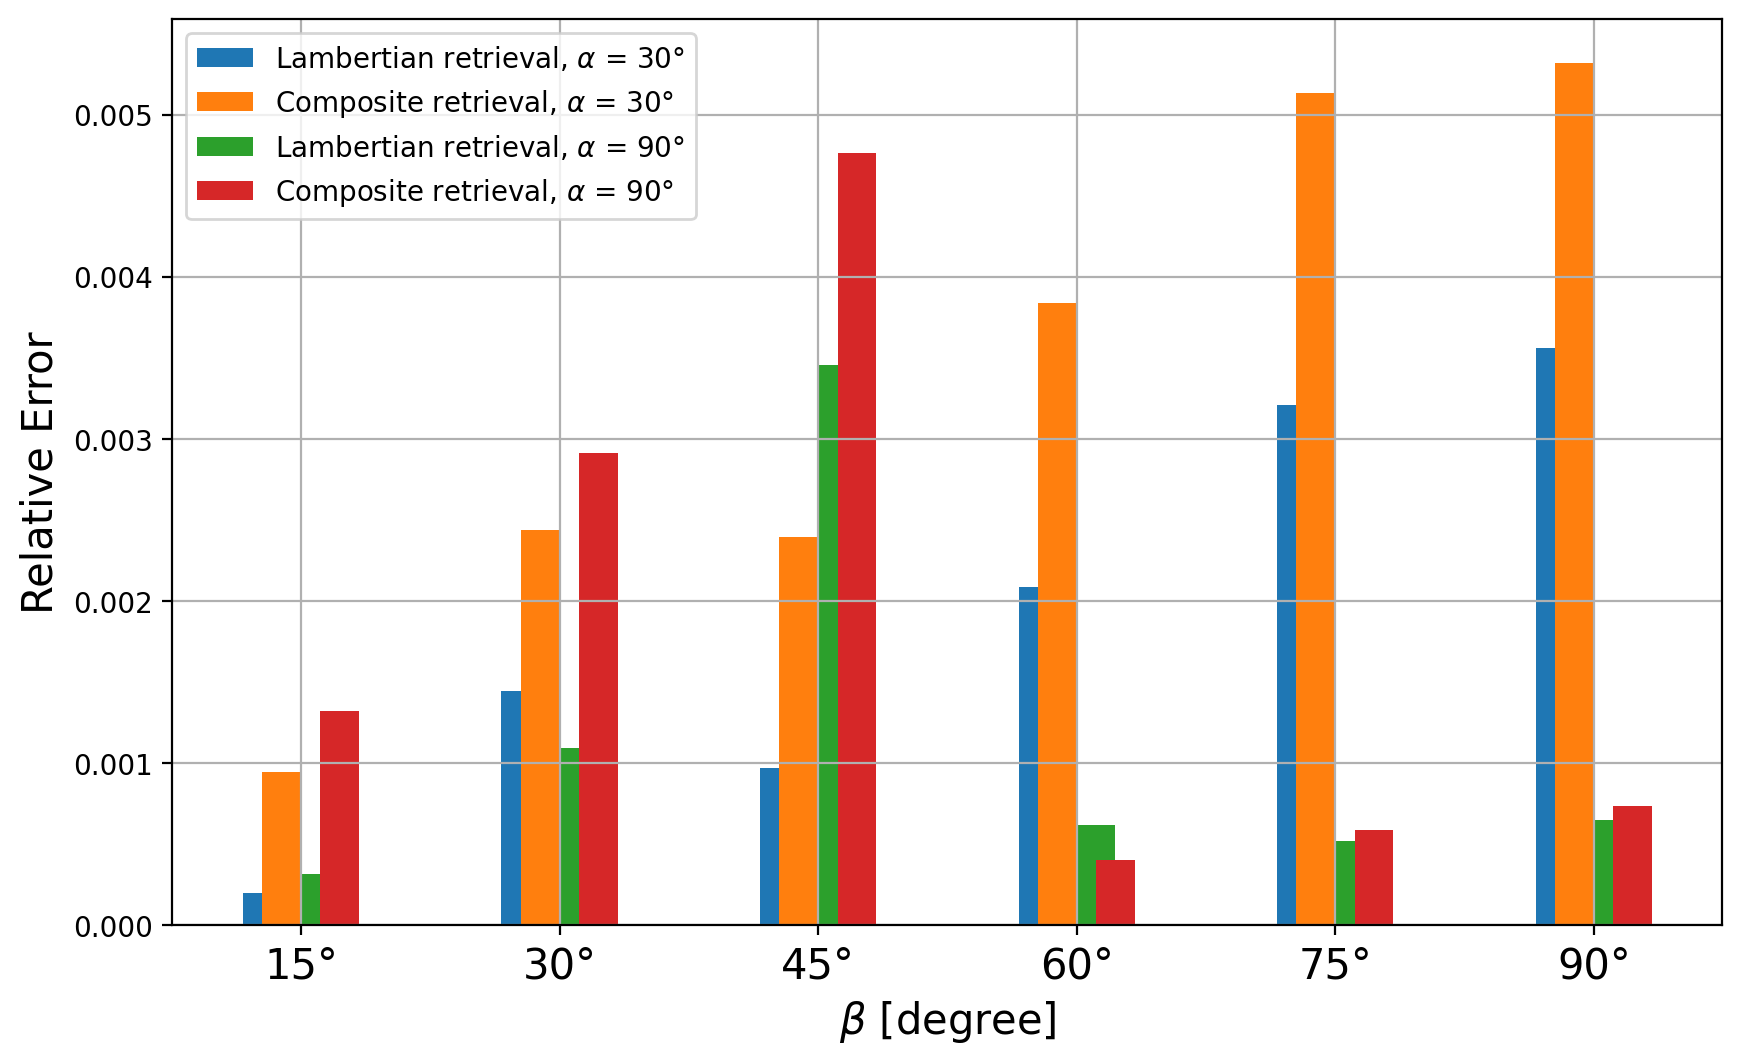

In [25]:
X = [np.pi/12,np.pi/6,np.pi/4,np.pi/3, 5*np.pi/12,np.pi/2]
labels = ['15°','30°','45°','60°','75°','90°' ]

lamb30 = lamb_lamb_errorlist[0][1:]
lamb90 = lamb_lamb_errorlist[2][1:]
comp30 = lamb_comp_errorlist[0][1:]
comp90 = lamb_comp_errorlist[2][1:]

x = np.arange(len(X))
width = 0.15

fig,ax = plt.subplots(figsize=(10,6), dpi=200)
rects1 = ax.bar(x-width, lamb30, width, label = 'Lambertian retrieval, '+r'$\alpha$ = 30°')
rects2 = ax.bar(x-width/2, comp30, width, label = 'Composite retrieval, '+r'$\alpha$ = 30°')
rects3 = ax.bar(x+width/2, lamb90, width, label = 'Lambertian retrieval, '+r'$\alpha$ = 90°')
rects4 = ax.bar(x+width, comp90, width, label = 'Composite retrieval, '+r'$\alpha$ = 90°')

ax.set_ylabel('Relative Error', fontsize = '15')
plt.xlabel(r'$\beta$ [degree]', fontsize = '15')
ax.set_xticks(x, labels, fontsize = '15')
plt.grid()
ax.legend()


#fig.tight_layout()

plt.show()

Composite signal, SVCR= 0.1


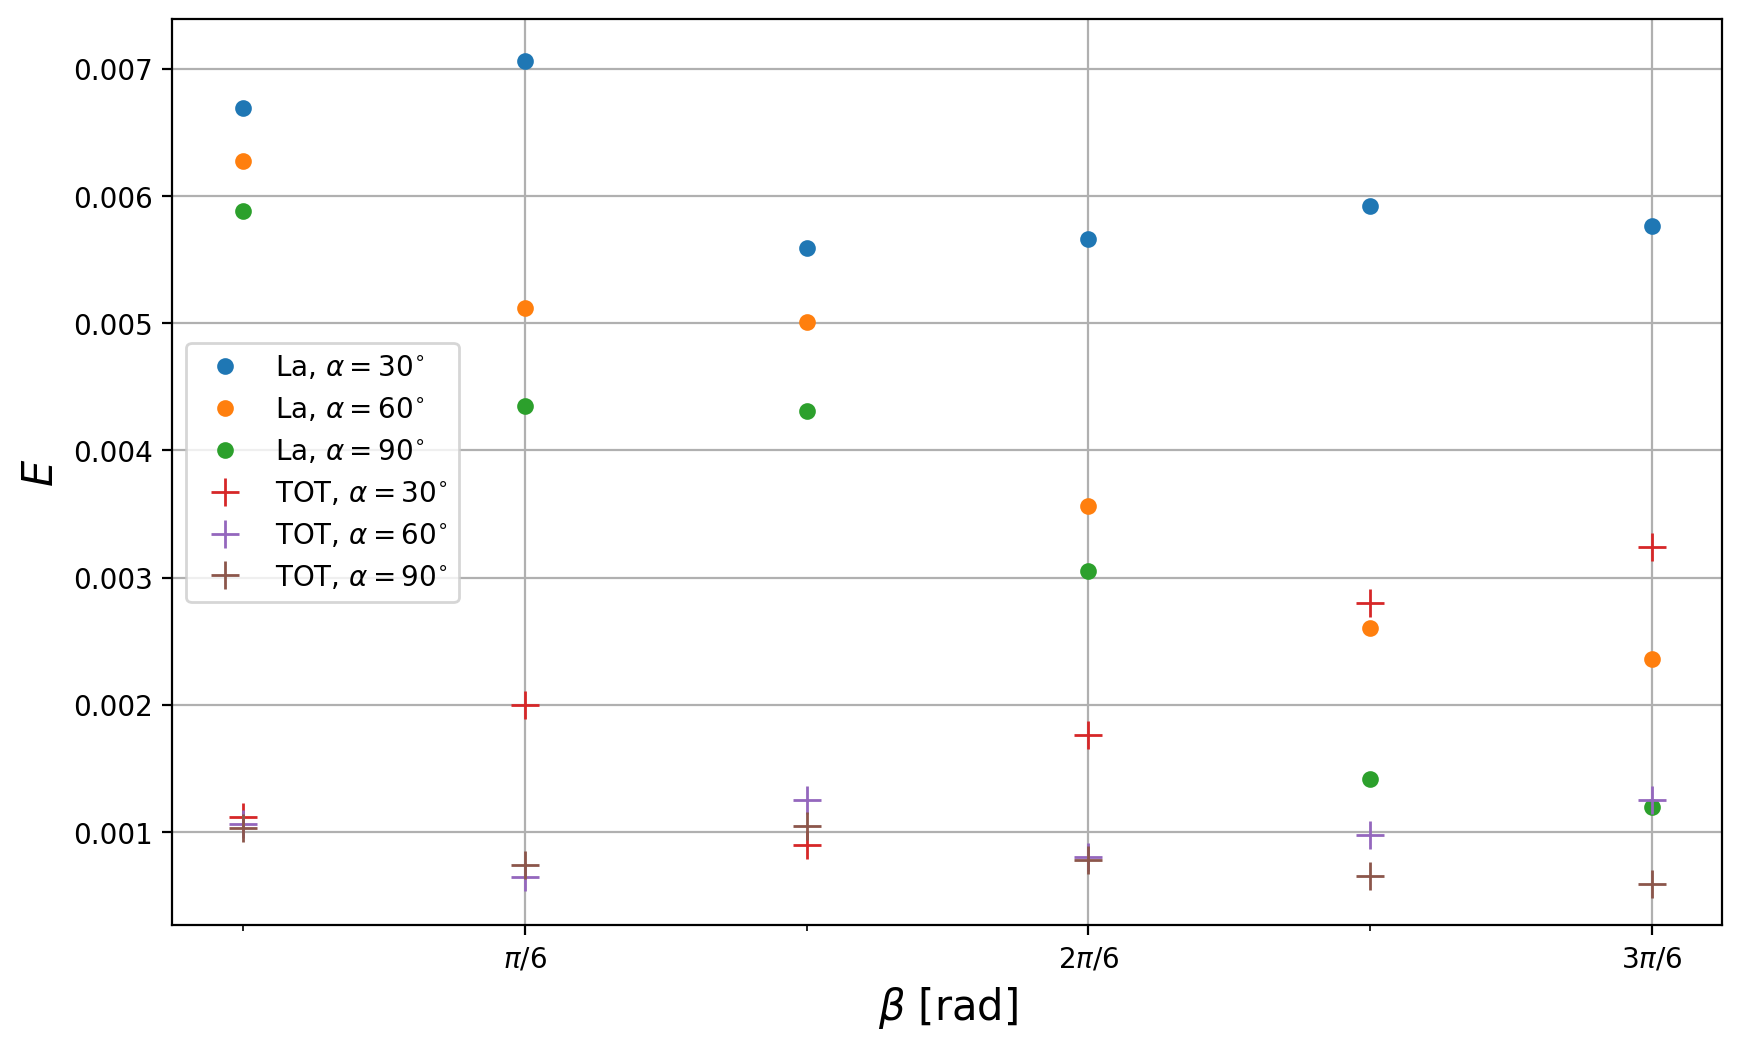

7.914783784443808 1 2


In [42]:
print('Composite signal, SVCR= '+str(SVCR))
f,ax=plt.subplots(figsize=(10,6), dpi=200)

ax.plot(betalist[1:],comp_lamb_errorlist[0][1:], '.',label= 'La, '+r'$\alpha = 30^{\circ}$', alpha = 1, markersize=10)
ax.plot(betalist[1:],comp_lamb_errorlist[1][1:], '.',label= 'La, '+r'$\alpha = 60^{\circ}$', alpha = 1, markersize=10)
ax.plot(betalist[1:],comp_lamb_errorlist[2][1:], '.',label= 'La, '+r'$\alpha = 90^{\circ}$', alpha = 1, markersize=10)

ax.plot(betalist[1:],comp_comp_errorlist[0][1:], '+',label= 'TOT, '+r'$\alpha = 30^{\circ}$', alpha = 1, markersize=10)
ax.plot(betalist[1:],comp_comp_errorlist[1][1:], '+',label= 'TOT, '+r'$\alpha = 60^{\circ}$', alpha = 1, markersize=10)
ax.plot(betalist[1:],comp_comp_errorlist[2][1:], '+',label= 'TOT, '+r'$\alpha = 90^{\circ}$', alpha = 1, markersize=10)

plt.xlabel(r'$\beta$ [rad]', fontsize = '15')
plt.ylabel(r'$E$', fontsize = '15')
plt.title('')
plt.legend()
plt.grid()
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 6))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
plt.show()

m = 0
for j in range(3):
    for i in range(6):
        if comp_lamb_errorlist[j,i+1]/comp_comp_errorlist[j,i+1] > m:
            m = comp_lamb_errorlist[j,i+1]/comp_comp_errorlist[j,i+1]
            a = j
            b = i+1
print(m,a,b)

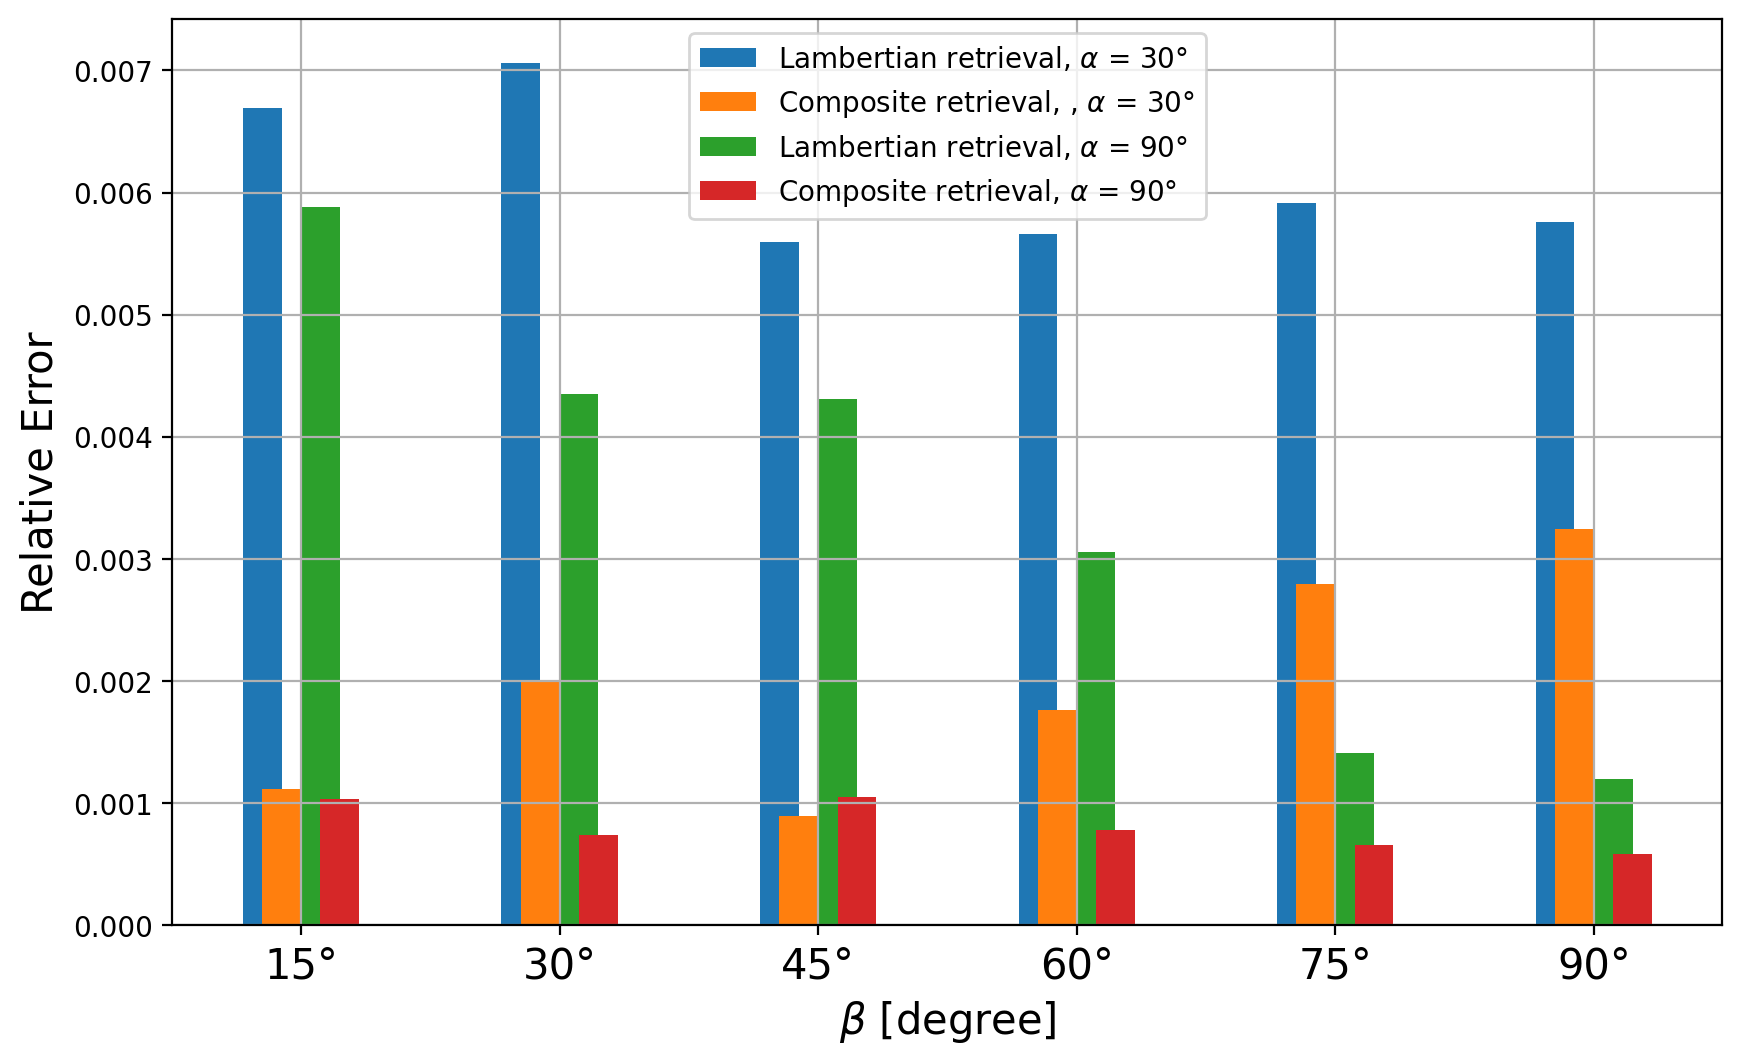

In [23]:
X = [np.pi/12,np.pi/6,np.pi/4,np.pi/3, 5*np.pi/12,np.pi/2]
labels = ['15°','30°','45°','60°','75°','90°' ]

lamb30 = comp_lamb_errorlist[0][1:]
lamb90 = comp_lamb_errorlist[2][1:]
comp30 = comp_comp_errorlist[0][1:]
comp90 = comp_comp_errorlist[2][1:]

x = np.arange(len(X))
width = 0.15

fig,ax = plt.subplots(figsize=(10,6), dpi=200)
rects1 = ax.bar(x-width, lamb30, width, label = 'Lambertian retrieval, '+r'$\alpha$ = 30°')
rects2 = ax.bar(x-width/2, comp30, width, label = 'Composite retrieval, , '+r'$\alpha$ = 30°')
rects3 = ax.bar(x+width/2, lamb90, width, label = 'Lambertian retrieval, '+r'$\alpha$ = 90°')
rects4 = ax.bar(x+width, comp90, width, label = 'Composite retrieval, '+r'$\alpha$ = 90°')

ax.set_ylabel('Relative Error', fontsize = '15')
plt.xlabel(r'$\beta$ [degree]', fontsize = '15')
ax.set_xticks(x, labels, fontsize = '15')
plt.grid()
ax.legend()


#fig.tight_layout()

plt.show()